<a href="https://www.kaggle.com/code/hriteshmaikap/cnn-batch-and-regularization?scriptVersionId=231210092" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covidct/COVID-CT-MetaInfo.xlsx
/kaggle/input/covidct/CT_NonCOVID/65%4.jpg
/kaggle/input/covidct/CT_NonCOVID/54%1.jpg
/kaggle/input/covidct/CT_NonCOVID/51%1.jpg
/kaggle/input/covidct/CT_NonCOVID/1814.png
/kaggle/input/covidct/CT_NonCOVID/1924.png
/kaggle/input/covidct/CT_NonCOVID/709.png
/kaggle/input/covidct/CT_NonCOVID/889.png
/kaggle/input/covidct/CT_NonCOVID/45.jpg
/kaggle/input/covidct/CT_NonCOVID/20.jpg
/kaggle/input/covidct/CT_NonCOVID/6%0.jpg
/kaggle/input/covidct/CT_NonCOVID/69%1.jpg
/kaggle/input/covidct/CT_NonCOVID/227.png
/kaggle/input/covidct/CT_NonCOVID/39%0.jpg
/kaggle/input/covidct/CT_NonCOVID/36%1.jpg
/kaggle/input/covidct/CT_NonCOVID/579.png
/kaggle/input/covidct/CT_NonCOVID/1048.png
/kaggle/input/covidct/CT_NonCOVID/39%4.jpg
/kaggle/input/covidct/CT_NonCOVID/33%1.jpg
/kaggle/input/covidct/CT_NonCOVID/177.png
/kaggle/input/covidct/CT_NonCOVID/754.png
/kaggle/input/covidct/CT_NonCOVID/104.png
/kaggle/input/covidct/CT_NonCOVID/1312.png
/kaggle/input/covidct

### Dependencies

In [2]:
!pip install torchinfo

In [3]:
import os  
import glob
import sklearn
from sklearn.model_selection import train_test_split

import PIL 
import numpy as np
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
from torchinfo import summary 

import torch.optim as optim
from IPython.display import Image
from torch.utils.data import DataLoader, Dataset

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

import cv2

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

### Pre-processing dataset

In [6]:
path = "/kaggle/input/covidct"
pos_files = glob.glob(os.path.join(path, "CT_COVID",'*.*'))
neg_files = glob.glob(os.path.join(path, 'CT_NonCOVID','*.*'))

images = pos_files + neg_files
labels = np.array([1]*len(pos_files)+[0]*len(neg_files))

# Split into train, validation, and test sets
images_tv, images_test, y_tv, y_test = train_test_split(images, labels, shuffle=True, test_size=0.2, random_state=123)
images_train, images_val, y_train, y_val = train_test_split(images_tv, y_tv, shuffle=True, test_size=0.25, random_state=123)

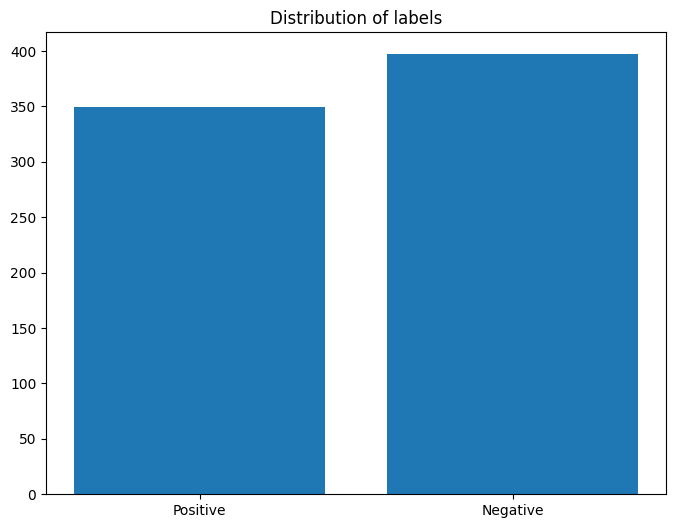

In [7]:
num_pos, num_neg = len(pos_files), len(neg_files)

plt.figure(figsize=(8, 6))
plt.title('Distribution of labels')
plt.bar(['Positive', 'Negative'], [num_pos, num_neg])
plt.show()

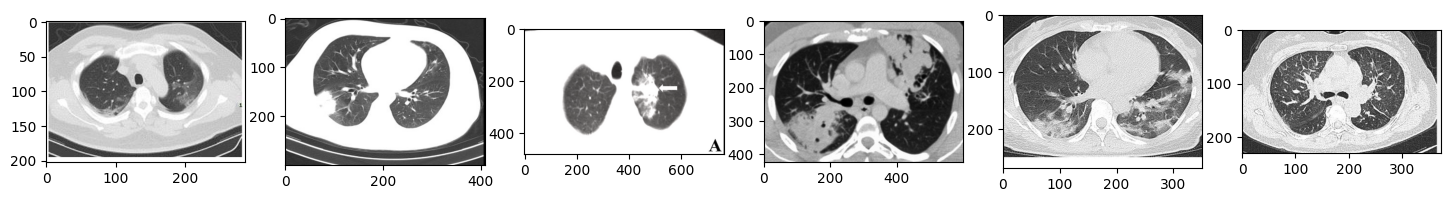

In [8]:
im = [cv2.imread(images_train[i]) for i in range(6)]

fig,ax = plt.subplots(ncols=6, figsize=(18,6))
for i in range(len(im)):
    ax[i].imshow(im[i],cmap='gray')

plt.show()

In [9]:
print(f'Number of samples in each set (train, val, test): {len(y_train), len(y_val), len(y_test)}')

print(f'Number of positive samples in each set: {y_train.sum(), y_val.sum(), y_test.sum()}')

Number of samples in each set (train, val, test): (447, 149, 150)
Number of positive samples in each set: (207, 71, 71)


## Data Augementation

In [10]:
class CT_Dataset(Dataset):
    def __init__(self, img_path, img_labels, img_transforms=None, grayscale=True, augment=False):
        self.img_path = img_path
        self.img_labels = torch.Tensor(img_labels)
        self.grayscale = grayscale
        self.augment = augment
        
        # Define augmentation transforms
        if augment:
            if grayscale:
                self.transforms = transforms.Compose([
                    transforms.Grayscale(num_output_channels=1),
                    transforms.Resize((250, 250)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomRotation(degrees=15),
                    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    transforms.ToTensor()
                ])
            else:
                self.transforms = transforms.Compose([
                    transforms.Resize((250, 250)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomRotation(degrees=15),
                    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])
        else:
            # Standard transforms without augmentation
            transform_list = [
                transforms.Resize((250, 250)),
                transforms.ToTensor()
            ]
            
            if grayscale:
                transform_list.insert(0, transforms.Grayscale(num_output_channels=1))
            else:
                transform_list.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
                
            self.transforms = transforms.Compose(transform_list)
    
    def __getitem__(self, index):
        # load image
        cur_path = self.img_path[index]
        cur_img = PIL.Image.open(cur_path).convert('RGB')
        cur_img = self.transforms(cur_img)
        return cur_img, self.img_labels[index]
    
    def __len__(self):
        return len(self.img_path)

def show_augmentation_examples(dataset, num_examples=5):
    """Display examples of original images and their augmented versions"""
    # Create a non-augmented dataset for comparison
    non_aug_dataset = CT_Dataset(dataset.img_path, dataset.img_labels, grayscale=dataset.grayscale, augment=False)
    
    fig, axs = plt.subplots(2, num_examples, figsize=(15, 6))
    
    for i in range(num_examples):
        # Get the same image from both datasets
        img_aug, _ = dataset[i]
        img_orig, _ = non_aug_dataset[i]
        
        # Convert tensor to numpy for display
        if dataset.grayscale:
            img_aug_np = img_aug.squeeze().numpy()
            img_orig_np = img_orig.squeeze().numpy()
        else:
            img_aug_np = img_aug.permute(1, 2, 0).numpy()
            img_orig_np = img_orig.permute(1, 2, 0).numpy()
            
            # Denormalize if RGB
            if not dataset.grayscale:
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img_aug_np = img_aug_np * std + mean
                img_orig_np = img_orig_np * std + mean
                
            # Clip values to valid range
            img_aug_np = np.clip(img_aug_np, 0, 1)
            img_orig_np = np.clip(img_orig_np, 0, 1)
        
        # Display images
        axs[0, i].imshow(img_orig_np, cmap='gray' if dataset.grayscale else None)
        axs[0, i].set_title('Original')
        axs[0, i].axis('off')
        
        axs[1, i].imshow(img_aug_np, cmap='gray' if dataset.grayscale else None)
        axs[1, i].set_title('Augmented')
        axs[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

## CNN Architectures

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1):
        super(SimpleCNN, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(256, 512, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(512, 512, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(12800, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x


In [12]:
class BatchNormCNN(nn.Module):
    def __init__(self, in_channels=1):
        super(BatchNormCNN, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(256, 512, 3),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(512, 512, 3),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(12800, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x

In [13]:
class RegCNN(nn.Module):
    def __init__(self, in_channels=1):
        super(RegCNN, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1),  # Add spatial dropout
            
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1),
            
            nn.Conv2d(128, 256, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),
            
            nn.Conv2d(256, 512, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),
            
            nn.Conv2d(512, 512, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3),
            
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(12800, 512),
            nn.ReLU(),
            nn.Dropout(0.4),  # Add dropout
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x

In [14]:
class BatchNormCNN(nn.Module):
    def __init__(self, in_channels=1):
        super(BatchNormCNN, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(256, 512, 3),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(512, 512, 3),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(12800, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x

In [15]:
class AugmentedCNN(nn.Module):
    def __init__(self, in_channels=1):
        super(AugmentedCNN, self).__init__()
        self.convnet = nn.Sequential(
            # First convolutional block
            nn.Conv2d(in_channels, 64, 3, padding=1),  # Added padding to preserve spatial dimensions
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1),  # Spatial dropout for convolutional layers
            
            # Second convolutional block
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1),
            
            # Third convolutional block
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),
            
            # Fourth convolutional block
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),
            
            # Fifth convolutional block
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3),
            
            nn.Flatten()
        )
        
        # Calculate the flattened size based on input dimensions and network architecture
        # With padding, the spatial dimensions after 5 max pooling layers would be 250/32 = ~7.8 (rounded to 7)
        # So 7x7x512 = 25088
        self.classifier = nn.Sequential(
            nn.Linear(25088, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x

In [16]:
class AugmentedCNN(nn.Module):
    def __init__(self, in_channels=1):
        super(AugmentedCNN, self).__init__()
        self.convnet = nn.Sequential(
            # First convolutional block
            nn.Conv2d(in_channels, 64, 3, padding=1),  # Added padding to preserve spatial dimensions
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1),  # Spatial dropout for convolutional layers
            
            # Second convolutional block
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1),
            
            # Third convolutional block
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),
            
            # Fourth convolutional block
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),
            
            # Fifth convolutional block
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3),
            
            nn.Flatten()
        )
        
        # Calculate the flattened size based on input dimensions and network architecture
        # With padding, the spatial dimensions after 5 max pooling layers would be 250/32 = ~7.8 (rounded to 7)
        # So 7x7x512 = 25088
        self.classifier = nn.Sequential(
            nn.Linear(25088, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.convnet(x)
        x = self.classifier(x)
        return x

In [17]:
def train_model(model, train_dataset, val_dataset, test_dataset, device, lr=0.0002, batch_size=32, epochs=35, l2=0, patience=5):
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Define optimizer with L2 regularization if specified
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    
    # Learning rate scheduler - modified to use CosineAnnealingLR for better performance
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr/10)
    
    # Define loss function for binary classification
    criterion = nn.BCEWithLogitsLoss()
    
    # Initialize variables for early stopping
    best_val_loss = float('inf')
    counter = 0
    
    # Initialize lists to track metrics
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'test_acc': None,
        'test_loss': None
    }
    
    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            
            # Backward pass and optimize
            loss.backward()
            # FIXED: Add gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # Update metrics
            train_loss += loss.item() * inputs.size(0)
            predictions = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                
                # Update metrics
                val_loss += loss.item() * inputs.size(0)
                predictions = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        
        # Learning rate scheduling
        scheduler.step()
        
        # Save metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Print progress
        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            # Save best model
            best_model = model.state_dict().copy()
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    # Load the best model
    model.load_state_dict(best_model)
    
    # Test phase
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            
            # Update metrics
            test_loss += loss.item() * inputs.size(0)
            predictions = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
            test_correct += (predictions == labels).sum().item()
            test_total += labels.size(0)
    
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_correct / test_total
    
    history['test_loss'] = test_loss
    history['test_acc'] = test_acc
    
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')
    
    return history

In [18]:
def plot_comparison(all_histories):
    # Get the number of epochs (use the longest history)
    max_epochs = max(len(hist['train_loss']) for hist in all_histories.values())
    epochs = range(1, max_epochs + 1)
    
    fig, ax = plt.subplots(2, 2, figsize=(20, 12))
    
    # Use a distinct color for each model
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    
    # Plot training loss
    ax[0, 0].set_title('Training Loss', fontsize=14)
    for i, (name, hist) in enumerate(all_histories.items()):
        ax[0, 0].plot(range(1, len(hist['train_loss']) + 1), hist['train_loss'], label=name, color=colors[i % len(colors)])
    ax[0, 0].set_xlabel('Epochs', fontsize=12)
    ax[0, 0].set_ylabel('Loss', fontsize=12)
    ax[0, 0].legend(fontsize=10)
    ax[0, 0].grid(True, linestyle='--', alpha=0.6)
    
    # Plot validation loss
    ax[0, 1].set_title('Validation Loss', fontsize=14)
    for i, (name, hist) in enumerate(all_histories.items()):
        ax[0, 1].plot(range(1, len(hist['val_loss']) + 1), hist['val_loss'], label=name, color=colors[i % len(colors)])
    ax[0, 1].set_xlabel('Epochs', fontsize=12)
    ax[0, 1].set_ylabel('Loss', fontsize=12)
    ax[0, 1].legend(fontsize=10)
    ax[0, 1].grid(True, linestyle='--', alpha=0.6)
    
    # Plot training accuracy
    ax[1, 0].set_title('Training Accuracy', fontsize=14)
    for i, (name, hist) in enumerate(all_histories.items()):
        ax[1, 0].plot(range(1, len(hist['train_acc']) + 1), hist['train_acc'], label=name, color=colors[i % len(colors)])
    ax[1, 0].set_xlabel('Epochs', fontsize=12)
    ax[1, 0].set_ylabel('Accuracy', fontsize=12)
    ax[1, 0].legend(fontsize=10)
    ax[1, 0].grid(True, linestyle='--', alpha=0.6)
    
    # Plot validation accuracy
    ax[1, 1].set_title('Validation Accuracy', fontsize=14)
    for i, (name, hist) in enumerate(all_histories.items()):
        ax[1, 1].plot(range(1, len(hist['val_acc']) + 1), hist['val_acc'], label=name, color=colors[i % len(colors)])
    ax[1, 1].set_xlabel('Epochs', fontsize=12)
    ax[1, 1].set_ylabel('Accuracy', fontsize=12)
    ax[1, 1].legend(fontsize=10)
    ax[1, 1].grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()
    
    # Create a bar chart comparing test accuracies
    plt.figure(figsize=(12, 6))
    model_names = list(all_histories.keys())
    test_accs = [hist['test_acc'] for hist in all_histories.values()]
    
    bars = plt.bar(model_names, test_accs, color=colors[:len(model_names)])
    plt.title('Test Accuracy Comparison', fontsize=16)
    plt.xlabel('Model', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.ylim(0, 1)
    
    # Add exact values on top of bars
    for i, acc in enumerate(test_accs):
        plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center', fontsize=12, fontweight='bold')
    
    plt.grid(True, linestyle='--', alpha=0.3, axis='y')
    plt.show()

In [19]:
def train_all_models(train_dataset, val_dataset, test_dataset, device):
    # Determine input channels from dataset
    sample_image, _ = train_dataset[0]
    in_channels = sample_image.shape[0]  # Get number of channels from sample image
    
    # Dictionary to store results
    all_histories = {}
    
    # 1. Train Simple CNN
    print("Training Simple CNN...")
    simple_cnn = SimpleCNN(in_channels=in_channels).to(device)
    all_histories['simple'] = train_model(
        simple_cnn, train_dataset, val_dataset, test_dataset, 
        device, lr=0.0002, batch_size=32, epochs=35, l2=0, patience=5
    )
    
    # 2. Train CNN with Batch Normalization
    print("\nTraining CNN with Batch Normalization...")
    batchnorm_cnn = BatchNormCNN(in_channels=in_channels).to(device)
    all_histories['batchnorm'] = train_model(
        batchnorm_cnn, train_dataset, val_dataset, test_dataset, 
        device, lr=0.0002, batch_size=32, epochs=35, l2=0, patience=5
    )
    
    # 3. FIXED: Train CNN with Regularization - now with both Dropout and L2
    print("\nTraining CNN with Regularization (Dropout + L2)...")
    reg_cnn = RegCNN(in_channels=in_channels).to(device)
    all_histories['regularized'] = train_model(
        reg_cnn, train_dataset, val_dataset, test_dataset, 
        # FIXED: Reduced L2 penalty to a more reasonable value
        device, lr=0.0002, batch_size=32, epochs=35, l2=0.0005, patience=7
    )
    
    # 4. Train CNN with Data Augmentation
    print("\nTraining CNN with Data Augmentation...")
    # Create augmented dataset
    train_dataset_aug = CT_Dataset(img_path=images_train, img_labels=y_train, grayscale=(in_channels==1), augment=True)
    # Show augmentation examples
    show_augmentation_examples(train_dataset_aug, num_examples=5)
    
    aug_cnn = AugmentedCNN(in_channels=in_channels).to(device)
    all_histories['augmented'] = train_model(
        aug_cnn, train_dataset_aug, val_dataset, test_dataset, 
        device, lr=0.0002, batch_size=32, epochs=40, l2=0.0005, patience=7
    )
    
    return all_histories

In [20]:
train_dataset = CT_Dataset(img_path=images_train, img_labels=y_train, grayscale=True)
val_dataset = CT_Dataset(img_path=images_val, img_labels=y_val, grayscale=True)
test_dataset = CT_Dataset(img_path=images_test, img_labels=y_test, grayscale=True)
    

Training Simple CNN...
Epoch 1/35 | Train Loss: 0.6913 | Train Acc: 0.5369 | Val Loss: 0.6919 | Val Acc: 0.5235 | LR: 0.000200
Epoch 2/35 | Train Loss: 0.6904 | Train Acc: 0.5369 | Val Loss: 0.6903 | Val Acc: 0.5235 | LR: 0.000199
Epoch 3/35 | Train Loss: 0.7027 | Train Acc: 0.5347 | Val Loss: 0.6901 | Val Acc: 0.5235 | LR: 0.000197
Epoch 4/35 | Train Loss: 0.6799 | Train Acc: 0.5369 | Val Loss: 0.6879 | Val Acc: 0.5235 | LR: 0.000194
Epoch 5/35 | Train Loss: 0.6773 | Train Acc: 0.5369 | Val Loss: 0.6758 | Val Acc: 0.5235 | LR: 0.000191
Epoch 6/35 | Train Loss: 0.6674 | Train Acc: 0.5570 | Val Loss: 0.6729 | Val Acc: 0.5436 | LR: 0.000187
Epoch 7/35 | Train Loss: 0.6573 | Train Acc: 0.5660 | Val Loss: 0.6678 | Val Acc: 0.5369 | LR: 0.000183
Epoch 8/35 | Train Loss: 0.6553 | Train Acc: 0.5951 | Val Loss: 0.6552 | Val Acc: 0.5570 | LR: 0.000178
Epoch 9/35 | Train Loss: 0.6202 | Train Acc: 0.6242 | Val Loss: 0.6269 | Val Acc: 0.6040 | LR: 0.000172
Epoch 10/35 | Train Loss: 0.5761 | Train 

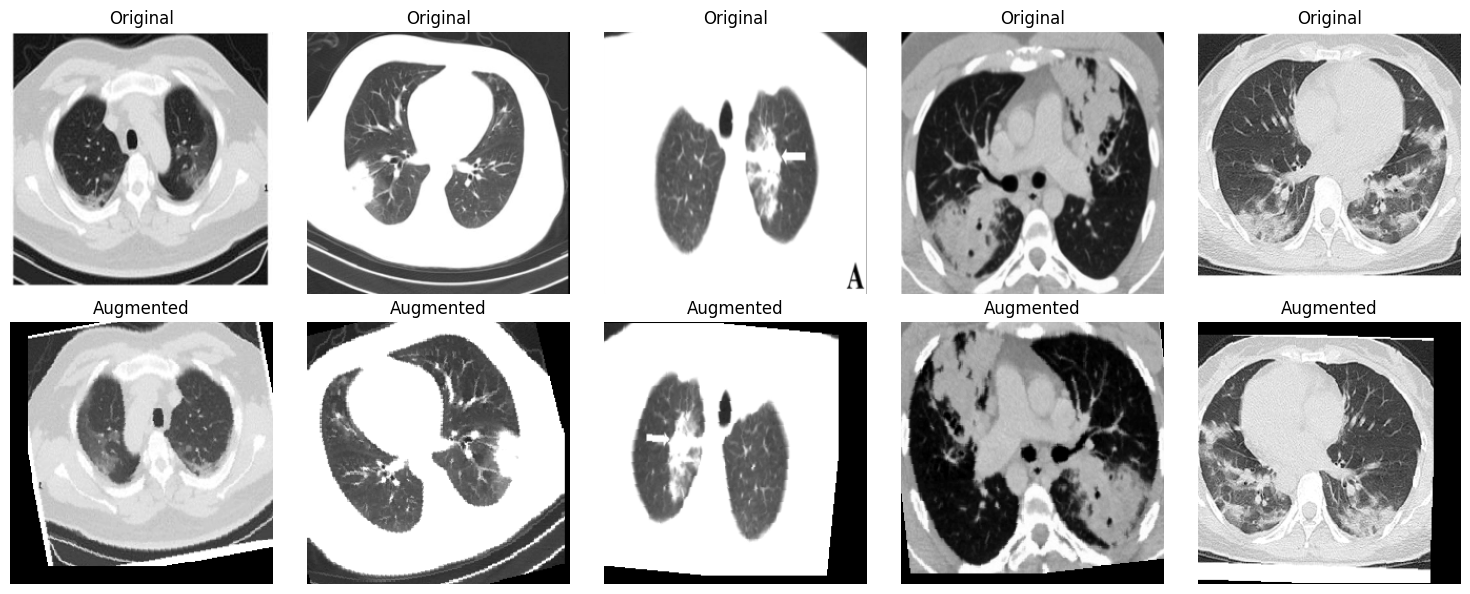

Epoch 1/40 | Train Loss: 0.7151 | Train Acc: 0.5414 | Val Loss: 0.7078 | Val Acc: 0.5235 | LR: 0.000200
Epoch 2/40 | Train Loss: 0.6800 | Train Acc: 0.5973 | Val Loss: 0.6947 | Val Acc: 0.5235 | LR: 0.000199
Epoch 3/40 | Train Loss: 0.6923 | Train Acc: 0.6063 | Val Loss: 0.6826 | Val Acc: 0.5235 | LR: 0.000198
Epoch 4/40 | Train Loss: 0.6565 | Train Acc: 0.6063 | Val Loss: 0.6624 | Val Acc: 0.6309 | LR: 0.000196
Epoch 5/40 | Train Loss: 0.6756 | Train Acc: 0.5861 | Val Loss: 0.6270 | Val Acc: 0.6779 | LR: 0.000193
Epoch 6/40 | Train Loss: 0.6557 | Train Acc: 0.5928 | Val Loss: 0.6396 | Val Acc: 0.5705 | LR: 0.000190
Epoch 7/40 | Train Loss: 0.6476 | Train Acc: 0.6376 | Val Loss: 0.6016 | Val Acc: 0.7114 | LR: 0.000187
Epoch 8/40 | Train Loss: 0.6333 | Train Acc: 0.6309 | Val Loss: 0.6073 | Val Acc: 0.6779 | LR: 0.000183
Epoch 9/40 | Train Loss: 0.6427 | Train Acc: 0.6577 | Val Loss: 0.5603 | Val Acc: 0.7315 | LR: 0.000178
Epoch 10/40 | Train Loss: 0.6435 | Train Acc: 0.6443 | Val Loss:

In [21]:
all_histories = train_all_models(train_dataset, val_dataset, test_dataset, device)

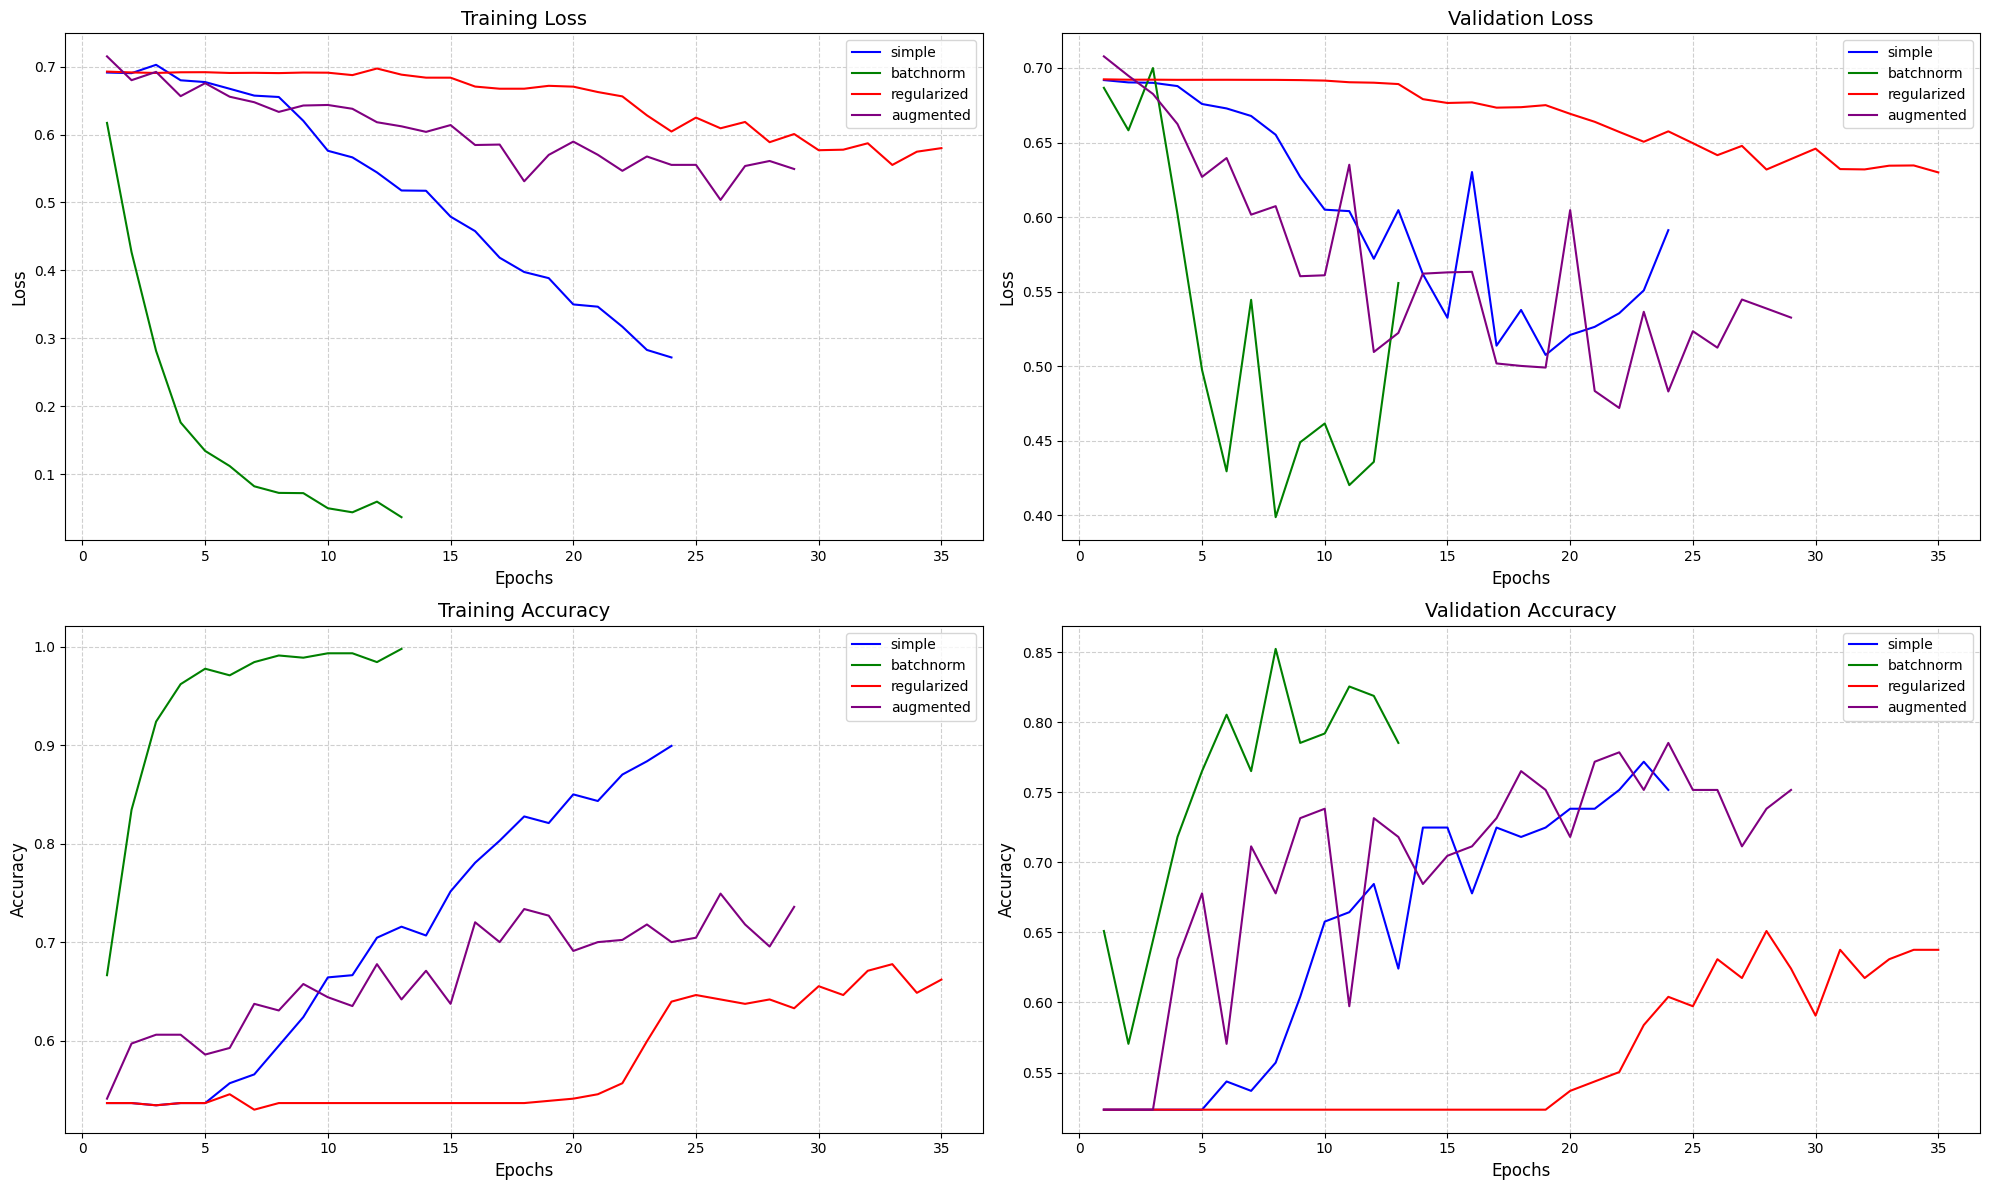

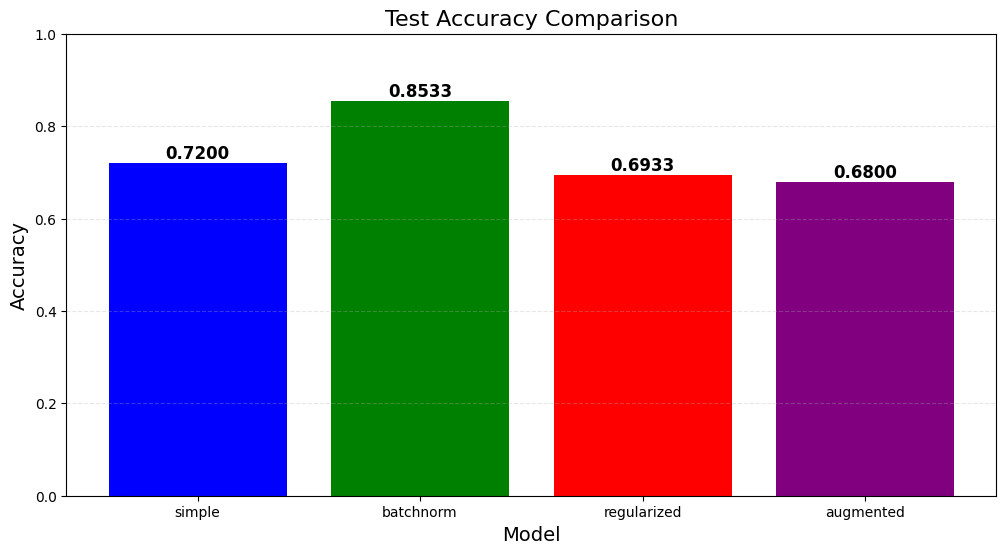

In [22]:
plot_comparison(all_histories)